In [273]:
import math
import numpy as np
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss

In [274]:

def der_f(f, x, epsilon=0.001):

    return (f(x + epsilon) - f(x)) / epsilon

def plot_f(f, N, x_min, x_max):

    x_vals = np.linspace(x_min, x_max, N)
    y_vals = []

    for i in x_vals:

        y_vals.append(f(i))

    fig = plt.figure(figsize = (10, 5))
    plt.plot(x_vals, y_vals)

def NewtonRaphson(market_price,
                  S,
                  K,
                  T,
                  r=0,
                  x0=1, cvg_e=.0001, x_min = -5, x_max = 5, N=1000):

    exitCondition = False
    x = x0
    iteration_num = 0

    def f(sigma):
    
        """
        - S: spot price
        - K: strike price
        - T: time to maturity
        - r: interest rate
        - sigma: volatility of underlying asset
        """
    
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
        call = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    
        return call - market_price
  
    while not exitCondition:

        # Increment iteration number
        iteration_num = iteration_num + 1

        # Calculate the new x value
        x = x - f(x) / der_f(f, x)

        # Exit condition if we are getting away from the zero 
        if abs(f(x)) < cvg_e or iteration_num > 100:
            print('        Newton-Raphson algorithm        ')
            print('        ------------------------        ')
            print(f'- Zero of the function f: {x}')
            print(f'- Number of iteration: {iteration_num}')
            print(f'- Tolerance: {cvg_e}')
            print('        ------------------------        ')
            return x

In [5]:
class MonteCarloPricer():
    
    def __init__(self, strike: float, spot: float, maturity: float, long_term_mean: float,
                 mean_rev_rate: float, initial_vol: float, brownian_corr: float,
                 vol_of_vol: float, n_paths: int, n_steps: int):

        # User-dependent parameters
        self.strike = strike
        self.spot = spot
        self.initial_vol = initial_vol # param 1
        self.maturity = maturity
        self.long_term_mean = long_term_mean # param 2
        self.mean_rev_rate = mean_rev_rate # param 3
        self.brownian_corr = brownian_corr # param 4
        self.vol_of_vol = vol_of_vol # param 5
        self.n_paths = n_paths
        self.n_steps = n_steps

        # Fixed parameters
        TRADING_DAYS = 256
        self.optionType = 'call'
        self.r = 0
        self.delta_time = self.maturity / TRADING_DAYS
        self.mu = 0.1
    
    
    def generateCIRPath(self):
        """
        Method to generate random paths for the CIR model.
        """
        # Create the list that stores the volatilities generated by the model
        vols = []
        
        # Scale the volatiltiy in terms of maturity
        scaled_vol = math.sqrt(self.maturity) * self.initial_vol
        
        # Generate brownian with scaled vol, zero mean and with appropriate size
        bm_vol = np.random.normal(loc=0,
                                  scale=math.sqrt(1/self.n_steps),
                                  size=self.n_steps)
        
        # Add initial volatility to the return list
        vols.append(self.initial_vol)
        
        # Iterate through all times and evolve vol
        for i in range(1, self.n_steps):

            # Innovation + previous volatility value
            new_vol = self.mean_rev_rate * (self.long_term_mean - vols[i-1]) * (1/self.n_steps) + \
                      math.sqrt(vols[i-1]) * bm_vol[i-1] + \
                      vols[i-1]
                        
            # Add the new volatility
            vols.append(new_vol)
        
            
        return vols, bm_vol # the latter that will be used to calculate the second correlated brownian term
    
    def generateCorrelatedW2(self, W1):
        """
        Function to generate correlated W2 - Brownian motion path given the W1 process and param of correlation rho.
        """
        
        # Create Zt Brownian Motion independent from W1
        Zt = np.random.normal(loc=0,
                                  scale=math.sqrt(1/self.n_steps),
                                  size=self.n_steps)
        
        # Create the process
        W2 = self.brownian_corr * W1 + math.sqrt(1 - self.brownian_corr ** 2) * Zt
        
        return W2
        
    
    def generateHeston(self, vol_process, W2):
        
        # Create empty list and initialize with initial spot value.
        heston_paths = [self.spot]
        
        # For all time steps, calculate the Heston process values.
        for i in range(1, self.n_steps):
            
            # New heston value
            new_heston_value = self.mu * heston_paths[i-1] * (1/self.n_steps) + \
                               vol_process[i-1] * heston_paths[i-1] * W2[i-1] + \
                               heston_paths[i-1]
            
            # Append the list with the new Heston value
            heston_paths.append(new_heston_value)
            
        return heston_paths
    
    def multiPaths(self, vol_process, W2):
        """
        Generate self.n_paths amount of paths for the MonteCarlo pricer method.
        """
        all_paths = []
        
        for t in range(self.n_paths):
        
            # Vol paths and brownian path
            vol_paths, W1 = self.generateCIRPath()

            # Generate correlated path
            W2 = self.generateCorrelatedW2(W1=W1)

            # Generate Heston process
            heston_paths = self.generateHeston(vol_process = vol_paths,
                                                W2=W2)
            
            all_paths.append(heston_paths)
            
        return all_paths
    
    def payoff(self, last_prices):
        
        diff_list = [x - self.strike for x in last_prices]
        
        print(diff_list)
        
        return None
    
    def visualizePaths(self, paths):
        """
        Method to visualize the parth 
        """
        
        fig = plt.figure(figsize=(21,10))
        plt.plot(pd.DataFrame(paths))
        plt.xlabel("Time Steps")
        plt.ylabel("Volatility")
        plt.title("Simulated Volatility with given parameters, " + str(self.n_paths) + ' number of paths')

## Correlated Brownian Motion construction methodology

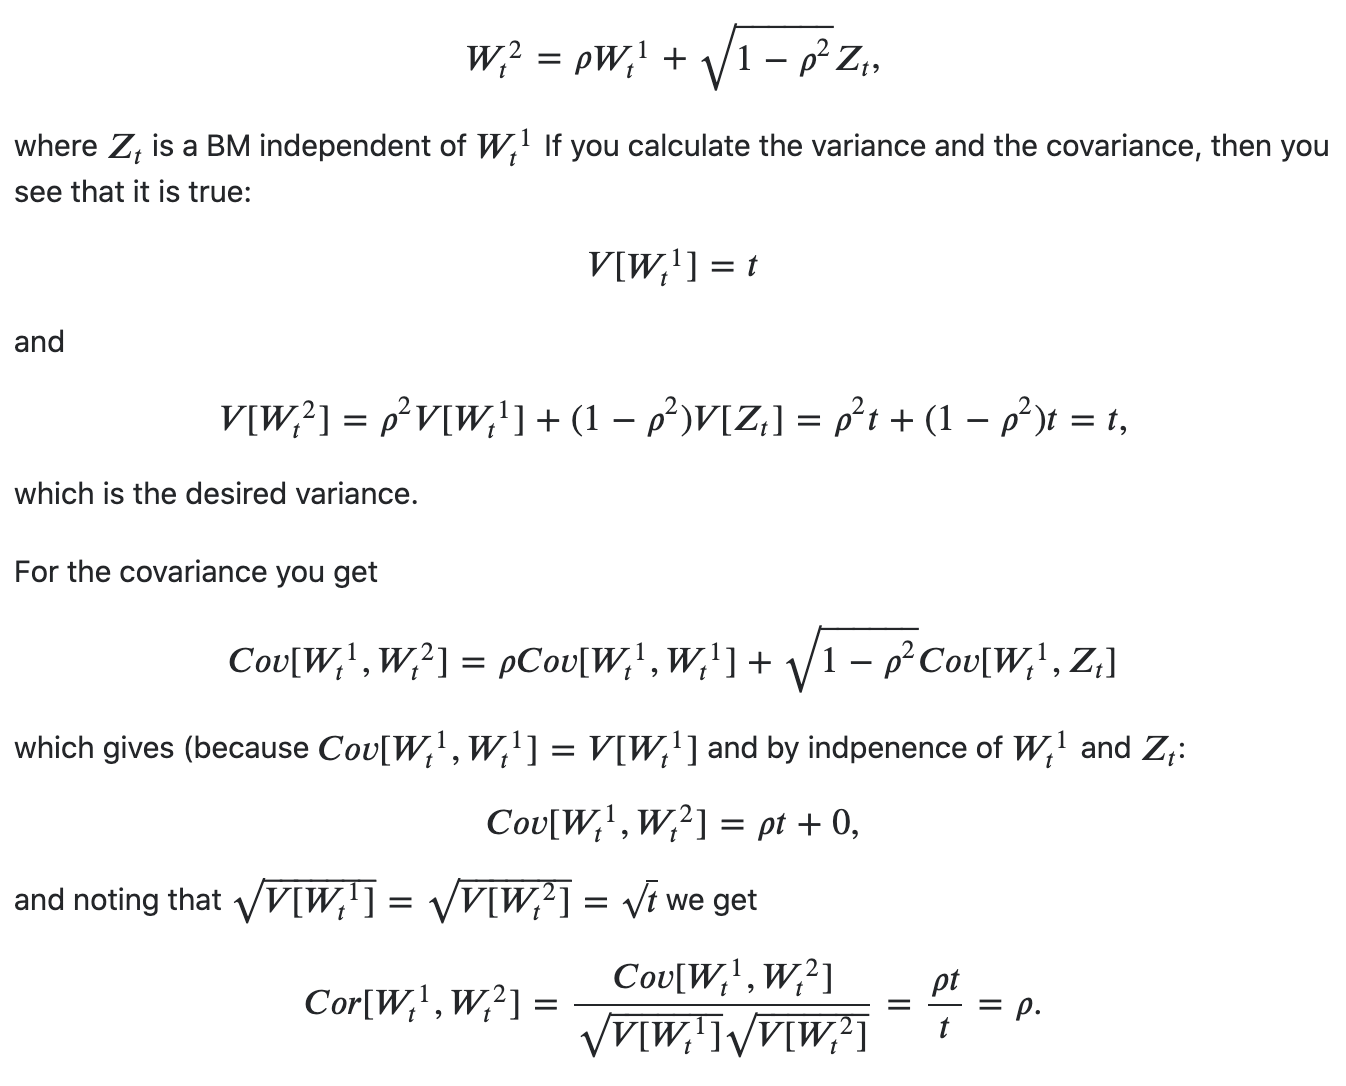

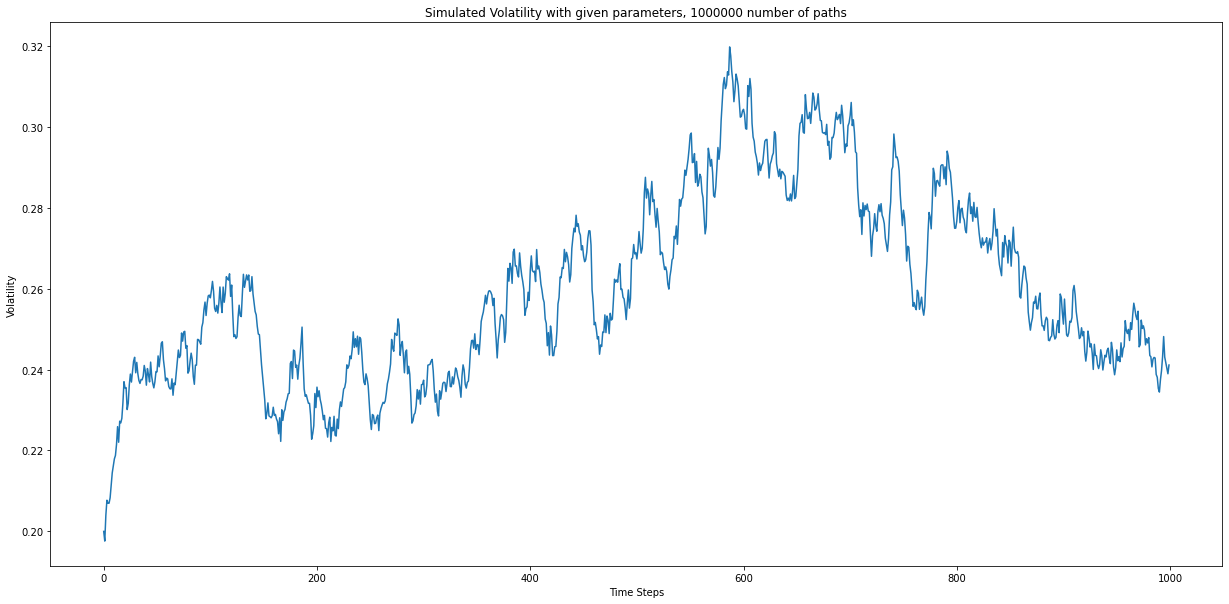

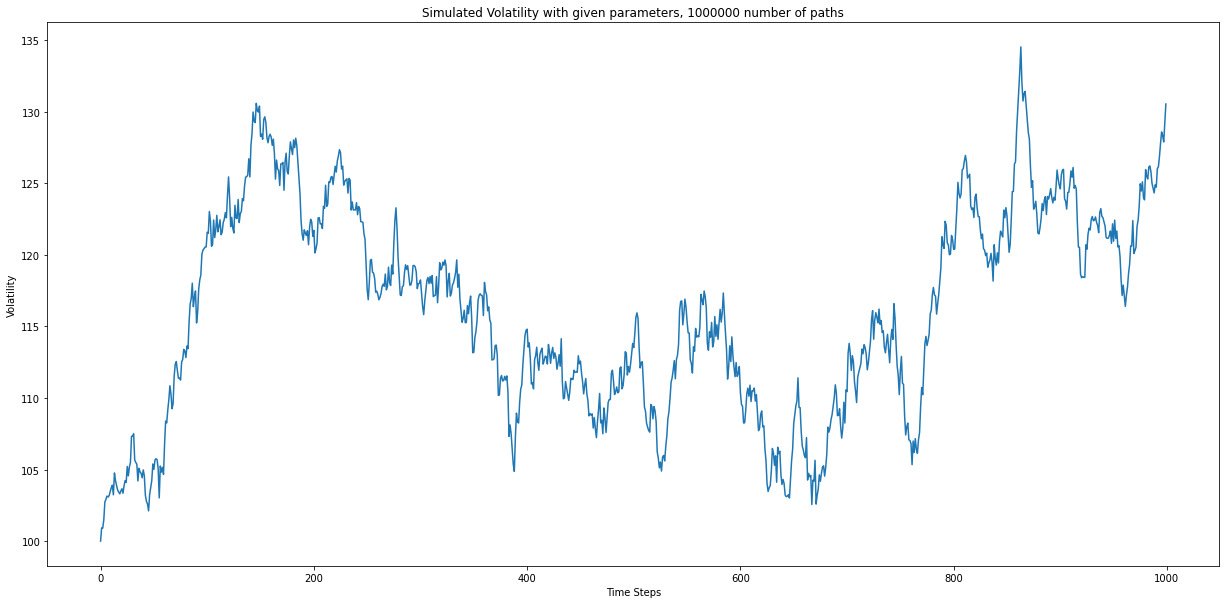

In [286]:
S = 100 # Spot price
K = 105 # Strike price
T = 1 # Maturity in years
r = 0 # Rates are null
initial_vol = 0.2
long_term_mean = 0.25
mean_rev_rate = 5
brownian_corr = 0.2
vol_of_vol = 0.2
steps = 1000 # Number of steps
N = 1000000 # Number of paths to generate

pricer = MonteCarloPricer(strike=K,
                          spot=S,
                          initial_vol = initial_vol,
                          maturity = T,
                          long_term_mean = long_term_mean,
                          mean_rev_rate = mean_rev_rate,
                          brownian_corr = brownian_corr,
                          vol_of_vol = vol_of_vol, 
                          n_steps = steps,
                          n_paths = N)

# Vol paths and brownian path
vol_paths, W1 = pricer.generateCIRPath()

# Visualize vol path
pricer.visualizePaths(vol_paths)

# Generate correlated path
W2 = pricer.generateCorrelatedW2(W1=W1)

# Generate Heston process
heston_paths = pricer.generateHeston(vol_process = vol_paths,
                                    W2=W2)

# Visualize Heston path
pricer.visualizePaths(heston_paths)

Text(0.5, 1.0, 'Simulated Correlated BM values')

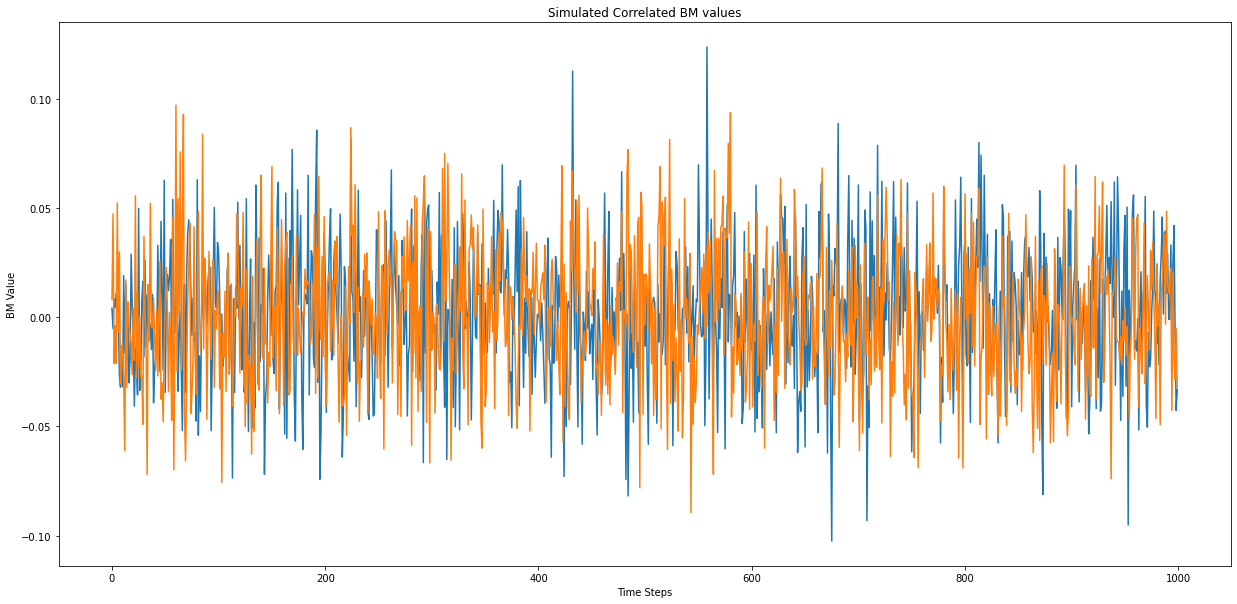

In [7]:
# Plot correlated BM processes

fig = plt.figure(figsize=(21,10))
plt.plot(pd.DataFrame(W1))
plt.plot(pd.DataFrame(W2))
plt.xlabel("Time Steps")
plt.ylabel("BM Value")
plt.title("Simulated Correlated BM values")

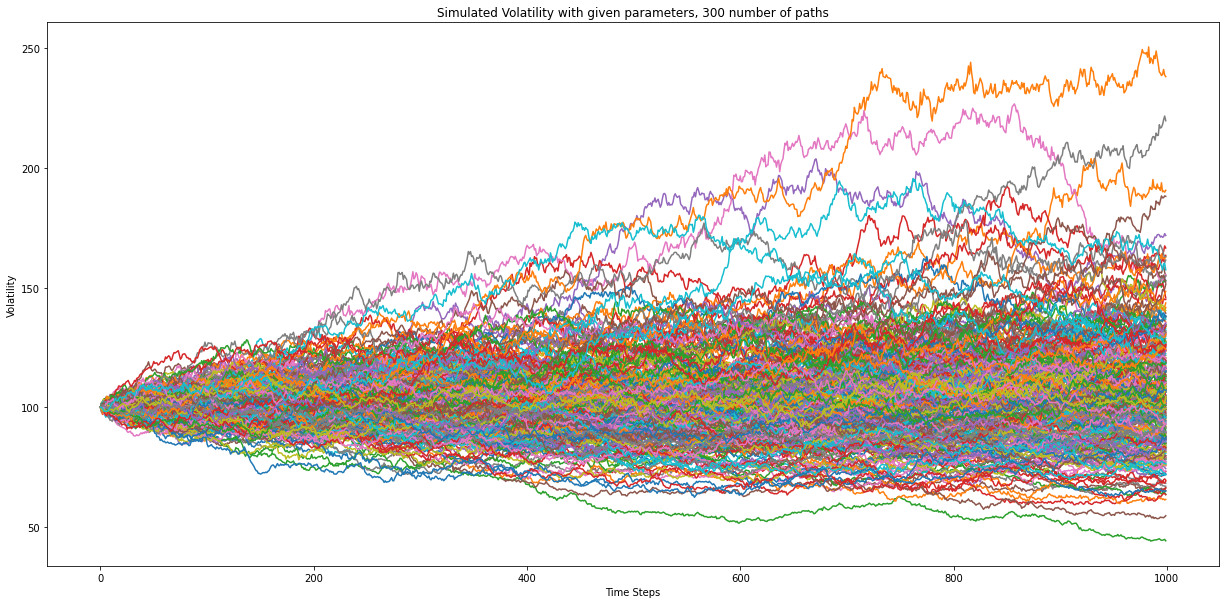

In [8]:
# Let's not visualize all paths generated by the Heston model
all_paths = pricer.multiPaths(vol_process = vol_paths, W2=W2)
all_paths_df = pd.DataFrame(all_paths).T

# Visualize all Heston path
pricer.visualizePaths(all_paths_df)

In [210]:
# Transform last prices to list
last_prices_list = list(all_paths_df.tail(1).values[0])

# Payoff can be obtained with the following line
np.mean(np.maximum([x - K for x in last_prices_list], 0))

10.341699709861519

In [10]:
# Prices generated from SmileSkewSmirk.ipynb

smile_prices = [27.91016566229309,
 17.0128799018497,
 7.965567455405804,
 8.1410120489642,
 11.135953579354965]

skew_prices = [22.265590130531834,
 13.589108116054796,
 9.94764496602258,
 10.118192116976672,
 15.096207835754342]

smirk_prices = [31.03743847867434,
 18.784217716370165,
 9.94764496602258,
 4.292010941409885,
 3.70588308589387]

In [254]:
def objective(x, S=100, n_steps=100, n_paths=3000, maturity=1):
    
    objective_sum = 0
    strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
    market_prices = [12.40, 9.59 ,8.28, 7.40, 6.86, 6.58 ,6.52 ,6.49 ,6.47, 6.46]
    
    
    for i in range(10):
        
        pricer = MonteCarloPricer(strike=strikes[i],
                                  spot=S,
                                  maturity = T,
                                  n_paths = N,
                                  n_steps = steps,
                                  # Five parameters to fill
                                  long_term_mean = x[0],
                                  mean_rev_rate = x[1],
                                  brownian_corr = x[2],
                                  vol_of_vol = 0, 
                                  initial_vol = x[3])

        # Vol paths and brownian path
        vol_paths, W1 = pricer.generateCIRPath()

        # Generate correlated path
        W2 = pricer.generateCorrelatedW2(W1=W1)

        # Generate Heston process
        heston_paths = pricer.generateHeston(vol_process = vol_paths,
                                            W2=W2)

        # Let's not visualize all paths generated by the Heston model
        all_paths = pricer.multiPaths(vol_process = vol_paths, W2=W2)
        all_paths_df = pd.DataFrame(all_paths).T
        
        # Transform last prices to list
        last_prices_list = list(all_paths_df.tail(1).values[0])

        # Payoff can be obtained with the following line
        call_price = np.mean(np.maximum([x - K for x in last_prices_list], 0))
        
        objective_sum = objective_sum + (call_price - market_prices[i]) ** 2
        
    return objective_sum

In [280]:
def price_by_heston(x, strike, S=100, n_steps=1000, n_paths=1000000, maturity=1/12):
    
        
    pricer = MonteCarloPricer(strike=strike,
                              spot=S,
                              maturity = T,
                              n_paths = N,
                              n_steps = steps,
                              # Five parameters to fill
                              long_term_mean = x[0],
                              mean_rev_rate = x[1],
                              brownian_corr = x[2],
                              vol_of_vol = 0, 
                              initial_vol = x[3])

    # Vol paths and brownian path
    vol_paths, W1 = pricer.generateCIRPath()

    # Generate correlated path
    W2 = pricer.generateCorrelatedW2(W1=W1)

    # Generate Heston process
    heston_paths = pricer.generateHeston(vol_process = vol_paths,
                                        W2=W2)

    # Let's not visualize all paths generated by the Heston model
    all_paths = pricer.multiPaths(vol_process = vol_paths, W2=W2)
    all_paths_df = pd.DataFrame(all_paths).T

    # Transform last prices to list
    last_prices_list = list(all_paths_df.tail(1).values[0])

    # Payoff can be obtained with the following line
    return np.mean(np.maximum([x - K for x in last_prices_list], 0))


# BS market price calculator
def BS_call_price(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    call = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [ ]:
%%time

for i in range(10000):

    S=100
    K=100
    T=1
    r=0
    sigma=.2

    heston_price = price_by_heston([0.02114454, 1.09555004, 0.36398018, 0.28693822], 100)
    bs_price = BS_call_price(S, K, T, r, .10)

    print(heston_price)
    print(bs_price)

In [275]:
# genetic algorithm search for continuous function optimization
from numpy.random import randint
from numpy.random import rand

 
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        # store
        decoded.append(value)
    return decoded
 
# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]
 
# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]
 
# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]
 

# Genetic Algorithm
def genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(decode(bounds, n_bits, pop[0]))
    # enumerate generations
    for gen in range(n_iter):
        # decode population
        decoded = [decode(bounds, n_bits, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %f" % (gen,  decoded[i], scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]
 
# define range for input
bounds = [[0, 10], [0, 5], [0, 1], [0, 0.02], [0, 1]]
# define the total iterations
n_iter = 4
# bits per variable
n_bits = 16
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / (float(n_bits) * len(bounds))
# perform the genetic algorithm search
best, score = genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
decoded = decode(bounds, n_bits, best)
print('f(%s) = %f' % (decoded, score))

>0, new best f([3.43017578125, 2.673797607421875, 0.0123443603515625, 0.00239288330078125, 0.715118408203125]) = 33332.479089
>0, new best f([9.946136474609375, 4.385833740234375, 0.49688720703125, 0.0032220458984375, 0.7193756103515625]) = 627.625500
>0, new best f([7.787017822265625, 2.4204254150390625, 0.9231414794921875, 0.01941253662109375, 0.657073974609375]) = 539.378544
>0, new best f([9.982757568359375, 3.55377197265625, 0.6646270751953125, 0.01744873046875, 0.879669189453125]) = 531.040767
>0, new best f([6.460113525390625, 0.04608154296875, 0.891021728515625, 0.014608154296875, 0.92352294921875]) = 439.568847
>0, new best f([6.791534423828125, 2.8949737548828125, 0.5999603271484375, 0.00510528564453125, 0.229827880859375]) = 317.114482
>0, new best f([0.099945068359375, 1.954803466796875, 0.151092529296875, 0.01350799560546875, 0.9676361083984375]) = 121.107635
>1, new best f([0.099945068359375, 1.349334716796875, 0.651092529296875, 0.01350067138671875, 0.96881103515625]) = 

In [205]:
heston_params = [0.5019683837890625, 0.8230743408203125, 0.5234527587890625, 0.009602813720703126, 0.2015380859375]
heston_smile_prices = []

for strike in [80, 90, 100, 110, 120]:
    heston_smile_prices.append(price_by_heston(x=heston_params,
               strike = strike))
    


In [206]:
heston_smile_prices

[15.974432342302656,
 17.594700669330283,
 17.084839713293253,
 15.312220443230405,
 13.203490898855286]

In [261]:
def visualize_heston_param_impact(x):
    
    strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
    prices = []
    impl_vols = []
    
    for strike in strikes:
    
        price = price_by_heston(x, strike)
        prices.append(price)
        
        impl_vol = NewtonRaphson(price, S=100, K=strike, T=1)
        impl_vols.append(impl_vol)
        
    smile_df = pd.DataFrame({
    'implied_vol': impl_vols,
    'strike': strikes})
    
    # Produce volatility smiles
    fig1, ax1 = plt.subplots()
    ax1.plot(smile_df['strike'], smile_df['implied_vol'])
    ax1.set_title('Volatility Smile')
        
    return prices

        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.20236854115536818
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.23691430883204043
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.24063133770156508
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.27734393814380354
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.24431209470935497
- Number of iter

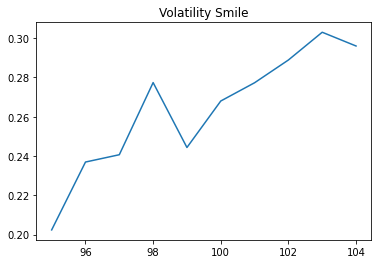

In [269]:
prices = visualize_heston_param_impact([
    .1, #long term mean
    3.15, #mean reversion rate
    0, #brownian corr
    0.0015, #vol of vol
    0.3, #initial vol
])

print(prices)

In [258]:
strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
bs_call_prices = []
heston_prices = []

for strike in strikes: 
    
    bs_call_prices.append(BS_call_price(S=100, K=strike, T=1, r=0, sigma=.22))
    heston_prices.append(price_by_heston([0.20026748, 0.5021858 , 0.0998081 , 0.40878052], strike))
    

In [259]:
bs_call_prices

[11.270164240439328,
 10.730613477381048,
 10.209894855838797,
 9.707860097342056,
 9.224323146589917,
 8.759062508463366,
 8.31182369246109,
 7.882321735104441,
 7.470243772494328,
 7.075251637053334]

In [260]:
heston_prices

[21.19958230290514,
 19.55230293470191,
 17.6942151261947,
 19.74684770238391,
 21.324783316825783,
 22.755215251110602,
 20.28655594912695,
 21.126955568894203,
 21.11084086828563,
 20.783149472599792]